In [ ]:
#| default_exp activations

# Activation stats

In [ ]:
#|export
from __future__ import annotations
import random,math,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset

from miniai.datasets import *
from miniai.learner import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [ ]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

## Baseline

In [ ]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

We want to train quickly, so that means training at a high learning rate. The faster we train (without diverging), the better we generalize because we see data less often (less chance of overfitting)

In [ ]:
from torcheval.metrics import MulticlassAccuracy

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [ ]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

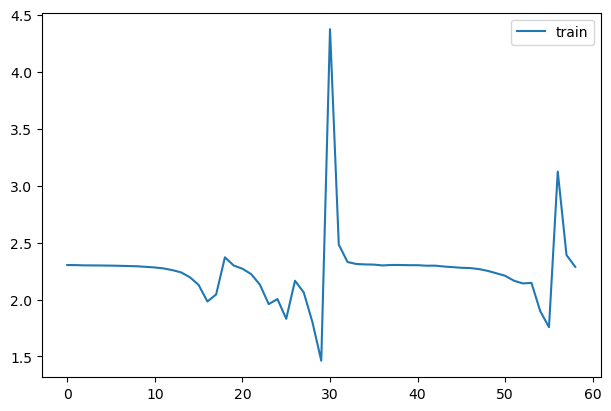

In [ ]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

We see that the model diverged. Something is wrong. Due to the fact that we used a large lr, but can we see inside what happened?

## Hooks

### Manual insertion

Keep stats of the activation in each layer, within the model

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds [i].append(to_cpu(x).std ())
        return x
    
    def __iter__(self): return iter(self.layers)

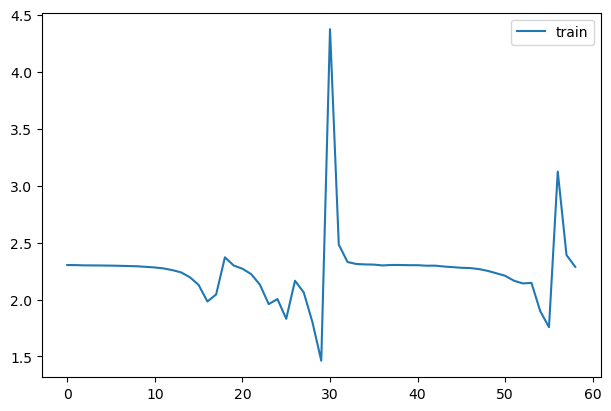

In [ ]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

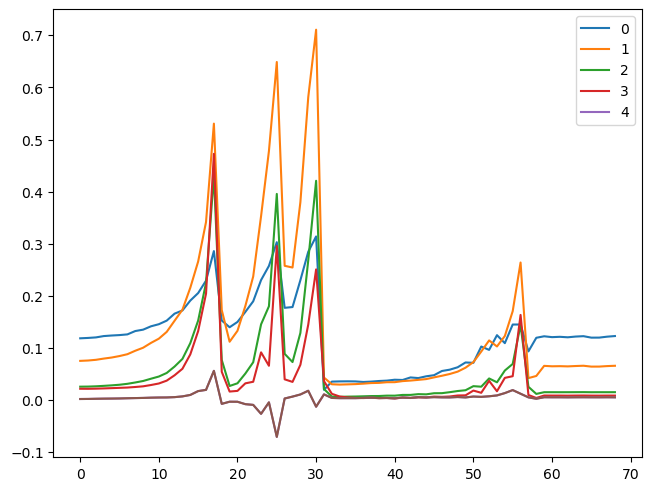

In [ ]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

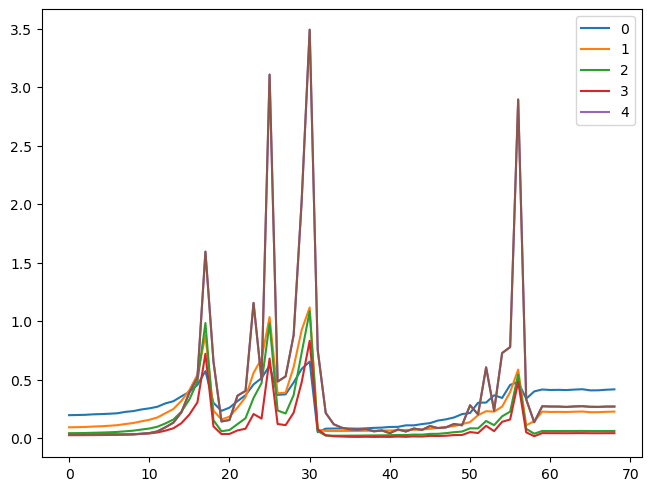

In [ ]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

This is a bad story:
- means is changing a lot, exploding exponentially and then crashing back to zero around epoch 30
- std is also close to 0 after epoch 30
This combines means that all activation are close to 0, so the network is dead !

What we want is a mean of the activation in each layer around 0 but a std around 1 (showing that the activation have various values around 0, nto all at 0

This is a classic plot of a model going wrong !

### Pytorch hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (**forward hook**) or the backward pass (**backward hook**). Hooks don't require us to rewrite the model.

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

A hook is attached to a layer, and needs to have a function that takes three arguments: **module, input, output**. Here we store the mean and std of the output in the correct position of our list.

In [ ]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [ ]:
def append_stats(i, mod, inp, outp):
    """i: layer number, mod: module, inp: input,  outp: output"""
    act_means[i].append(to_cpu(outp).mean())
    act_stds [i].append(to_cpu(outp).std())

In [ ]:
for i,m in enumerate(model): 
    m.register_forward_hook(partial(append_stats, i))

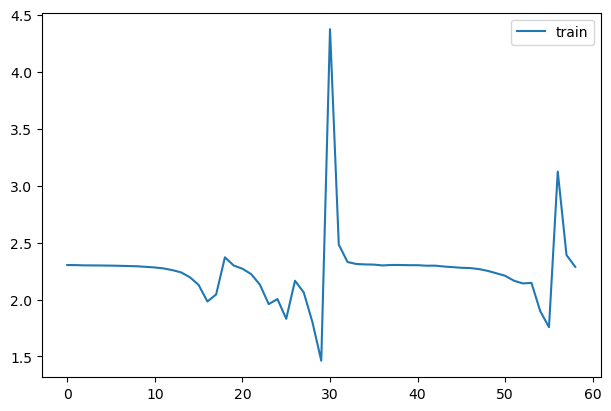

<miniai.learner.Learner>

In [ ]:
fit(model)

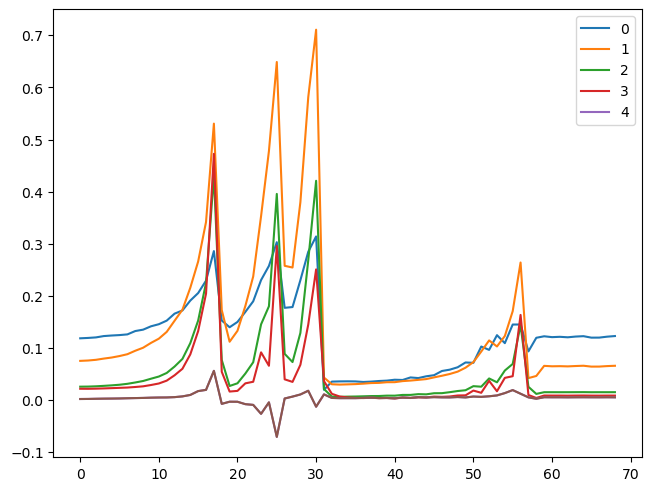

In [ ]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

#### Experiments with hooks

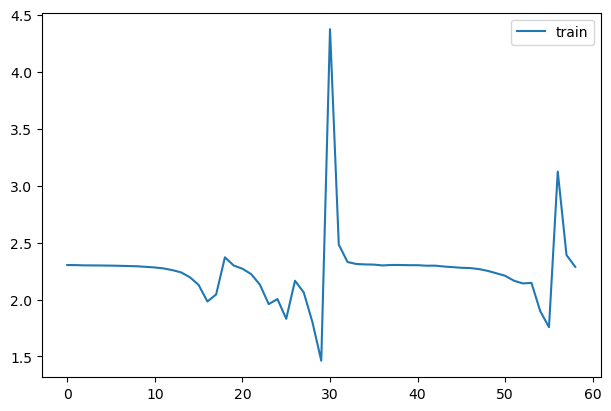

<miniai.learner.Learner>

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

inp_shapes = [[] for _ in model]
outp_shapes = [[] for _ in model]

def layer_shapes(i, mod, inp, outp):
    """Save the shapes of the layer input and output tensors, at each batch """
    inp_shapes[i].append(to_cpu(inp)[0].shape)
    outp_shapes[i].append(to_cpu(outp)[0].shape)

for i,m in enumerate(model): 
    m.register_forward_hook(partial(layer_shapes, i))

fit(model)

In [ ]:
# inp_shapes[0]

In [ ]:
# Only the shape does not change (except the batch size for the last batch), so we only keep the first one
for n in range(6):
    print(inp_shapes[n][0], outp_shapes[n][0])


torch.Size([1024, 1, 28, 28]) torch.Size([8, 14, 14])
torch.Size([1024, 8, 14, 14]) torch.Size([16, 7, 7])
torch.Size([1024, 16, 7, 7]) torch.Size([32, 4, 4])
torch.Size([1024, 32, 4, 4]) torch.Size([64, 2, 2])
torch.Size([1024, 64, 2, 2]) torch.Size([10, 1, 1])
torch.Size([1024, 10, 1, 1]) torch.Size([10])


### Hook class

We can refactor this into a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [ ]:
#| export
class Hook():
    """Pytorch hook using function `f` as hook function (f(hook, mod, inp, outp))"""
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [ ]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [ ]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

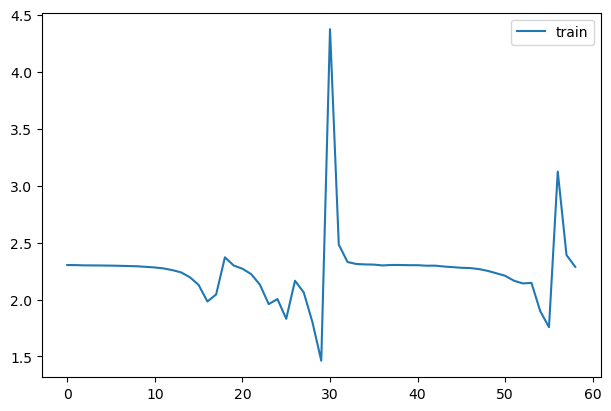

In [ ]:
learn = fit(model)

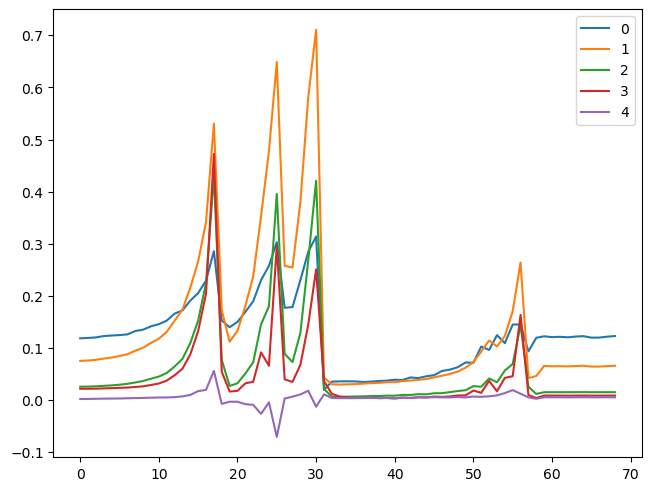

In [ ]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

#### Experiment with hook class

In [ ]:
def layer_shapes(hook, mod, inp, outp):
    if not hasattr(hook, 'shapes'): hook.shapes = ([], [])
    hook.shapes[0].append(inp[0].shape)
    hook.shapes[1].append(outp[0].shape)

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [ ]:
# list(model.children())

In [ ]:
shape_hooks = [Hook(l, layer_shapes) for l in model.children()]

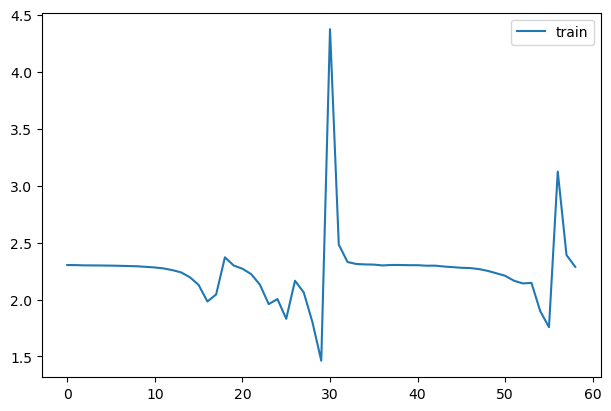

<miniai.learner.Learner>

In [ ]:
fit(model)

In [ ]:
for h in shape_hooks:
    print(h.shapes[0][0], h.shapes[1][0])

torch.Size([1024, 1, 28, 28]) torch.Size([8, 14, 14])
torch.Size([1024, 8, 14, 14]) torch.Size([16, 7, 7])
torch.Size([1024, 16, 7, 7]) torch.Size([32, 4, 4])
torch.Size([1024, 32, 4, 4]) torch.Size([64, 2, 2])
torch.Size([1024, 64, 2, 2]) torch.Size([10, 1, 1])
torch.Size([1024, 10, 1, 1]) torch.Size([10])


### A Hooks class

#### Context managers (advanced)

Will use another way (more general) to create a context manager, using a class with methods `__enter__` and `__exit__`

In [ ]:
class DummyCtxMgr:
    def __enter__(self, *args):
        """Code to run after the with statement. if there is a 'as foo', foo will catch the returned value, i.e. self"""
        print("let's go!")
        return self
    def __exit__ (self, *args): 
        """Code to run after the code within the context is done"""
        print("all done!")
        
    def hello(self): print("hello.")

In [ ]:
with DummyCtxMgr() as dcm: 
    dcm.hello()

let's go!
hello.
all done!


In [ ]:
with DummyCtxMgr() as dcm:
    print('any code')

let's go!
any code
all done!


Context manager class can inherit from `list`

In [ ]:
class DummyList(list):
    def __init__(self, *args): super().__init__(*args)
    def __delitem__(self, i):
        print(f"Say bye to item {i}")
        super().__delitem__(i)

In [ ]:
dml = DummyList([1,3,2])
dml

[1, 3, 2]

In [ ]:
del(dml[2])
dml

Say bye to item 2


[1, 3]

In [ ]:
class MyContextMgrList(list):
    def __init__(self, *args): super().__init__(*args)    
    def __enter__(self, *args):
        print(f"{'-'*80}\nCode upon opening the context")
        print(f"Context manager includes list {self}\n{'-'*80}")
        return self
    def __exit__ (self, *args):
        print(f"{'-'*80}\nCode at the end of the context\n{'-'*80}")
    def __delitem__(self, i):
        print(f"Deleting item {i} in context list")
        super().__delitem__(i)

In [ ]:
with MyContextMgrList('a b c d e'.split(' ')) as dml:
    print('Run the code once for each value in context manager list')
    for i, p in enumerate(dml):
        print(f" {i}. Run custom code with parameter {p}")

--------------------------------------------------------------------------------
Code upon opening the context
Context manager includes list ['a', 'b', 'c', 'd', 'e']
--------------------------------------------------------------------------------
Run the code once for each value in context manager list
 0. Run custom code with parameter a
 1. Run custom code with parameter b
 2. Run custom code with parameter c
 3. Run custom code with parameter d
 4. Run custom code with parameter e
--------------------------------------------------------------------------------
Code at the end of the context
--------------------------------------------------------------------------------


#### hooks class

In [ ]:
#| export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        """can iterate on self because self is a list"""
        for h in self: h.remove()

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

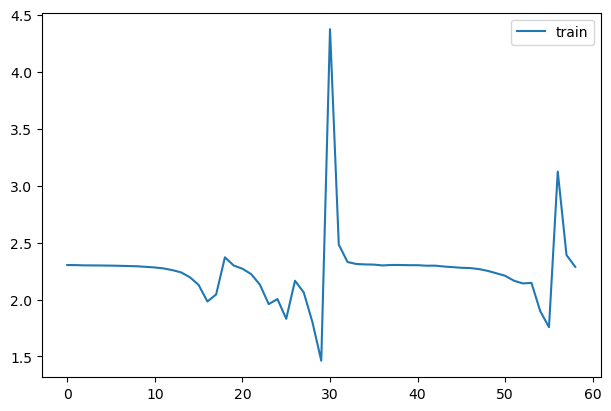

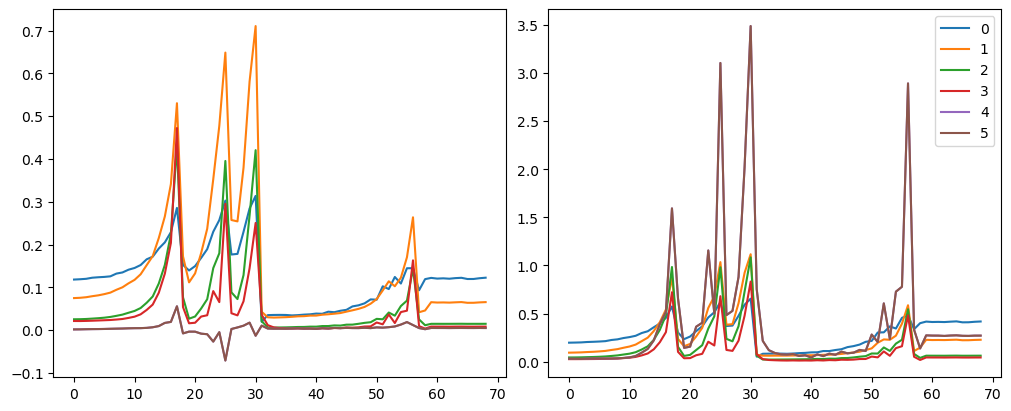

In [ ]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

### HooksCallback

In [ ]:
#| export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if learn.training: self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [ ]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

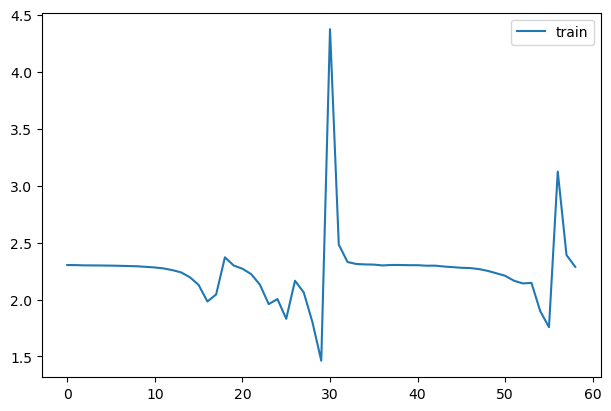

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

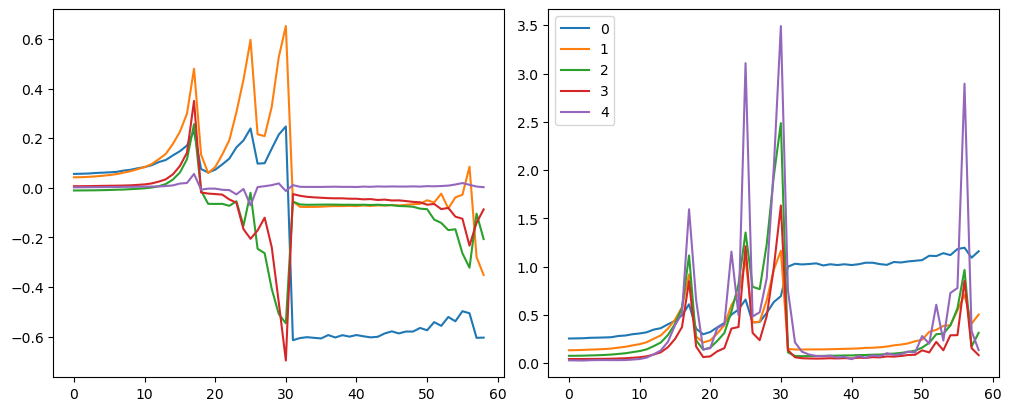

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

## Histograms

In [ ]:
#| export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

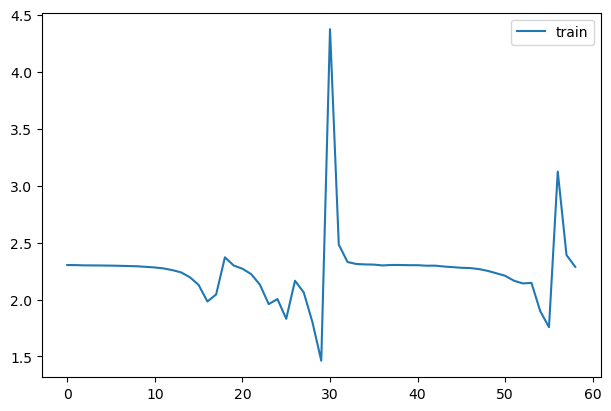

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [ ]:
#| export
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

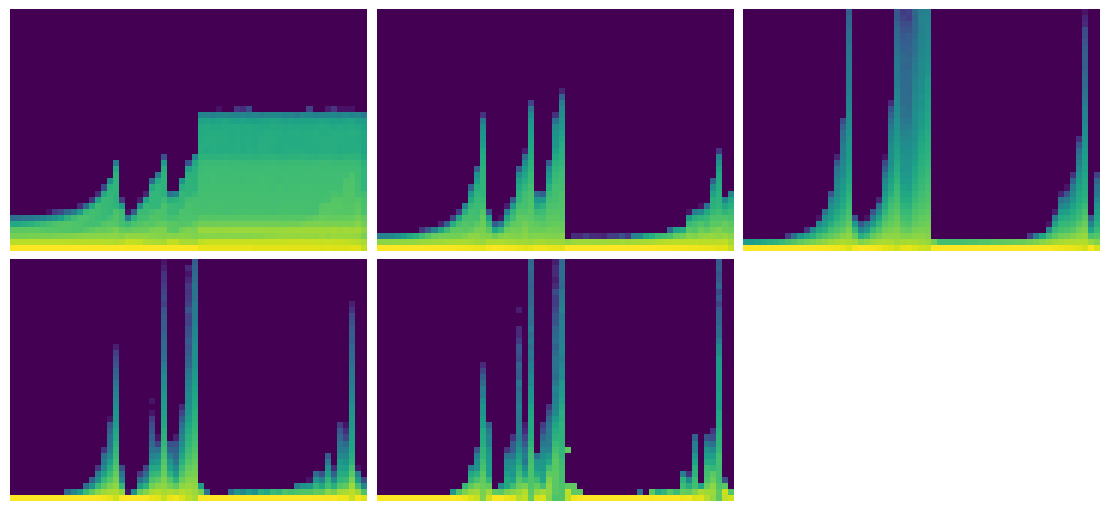

In [ ]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower', cmap='viridis')

Comment in the lesson 16 video is [here](https://youtu.be/GNAE6K228ck?t=5650)


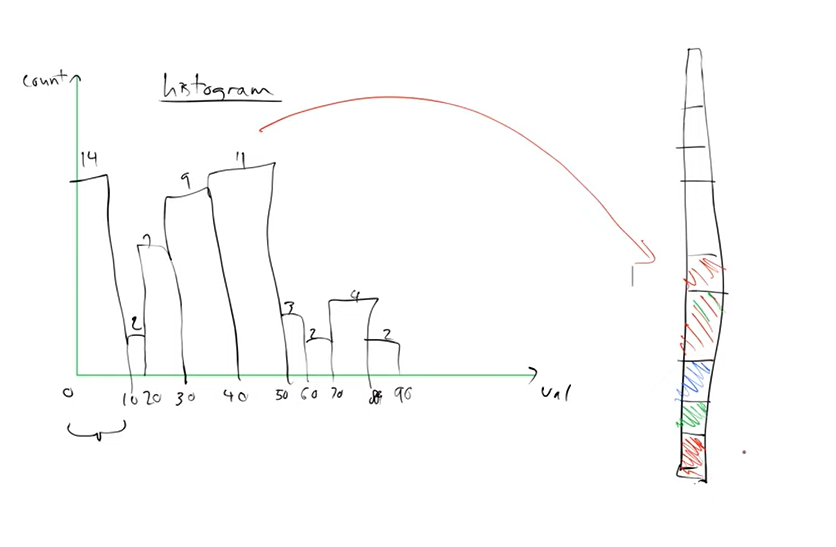


In [ ]:
#| export
def get_min(h):
    """Take the smallest activation value and show its ratios vs the total count. Should be small"""
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

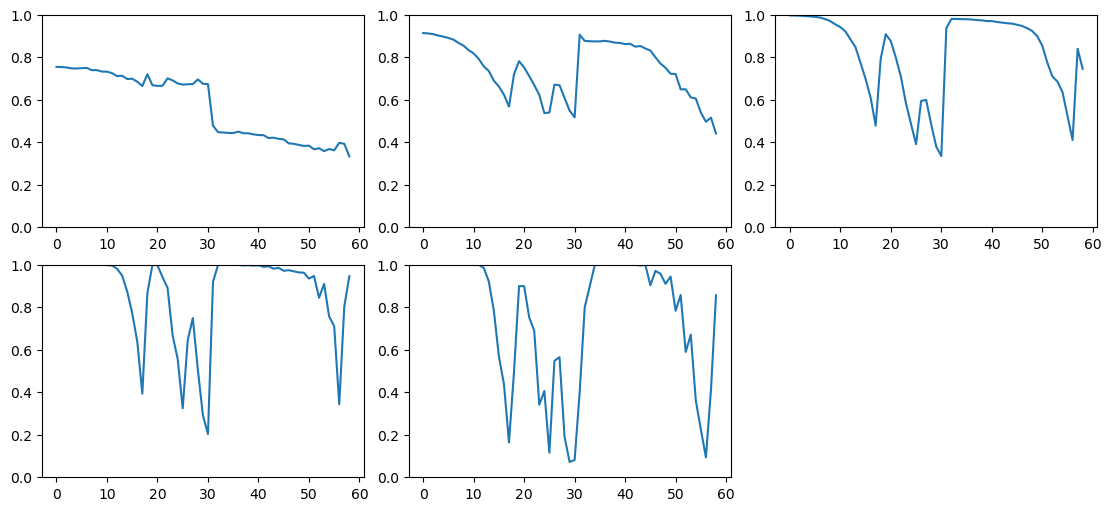

In [ ]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

## ActivationStats

In [ ]:
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [ ]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

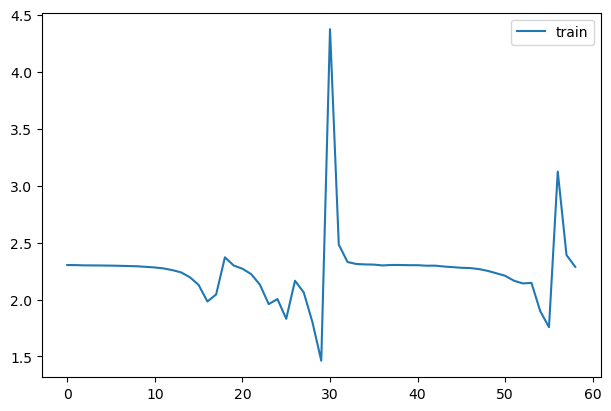

In [ ]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

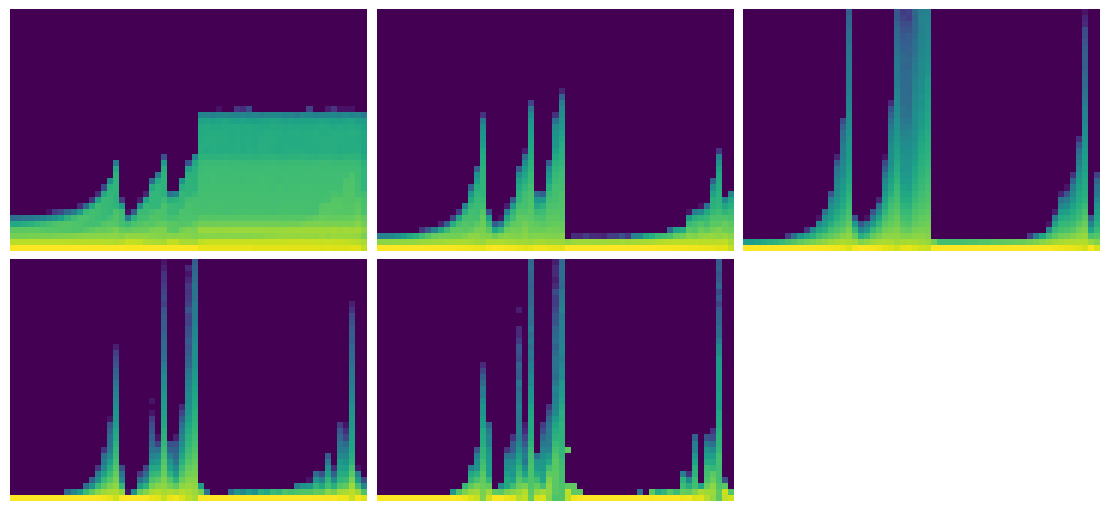

In [ ]:
astats.color_dim()

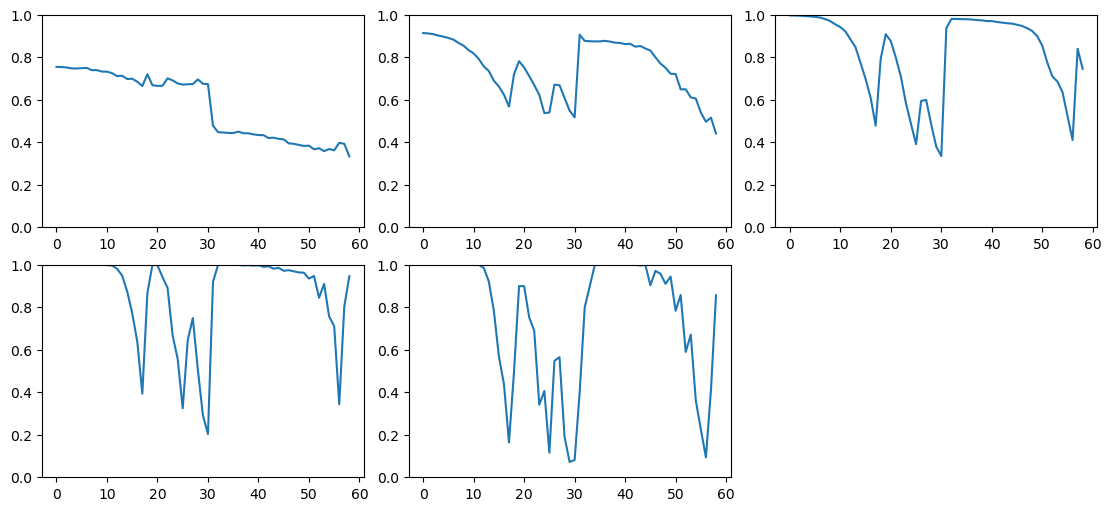

In [ ]:
astats.dead_chart()

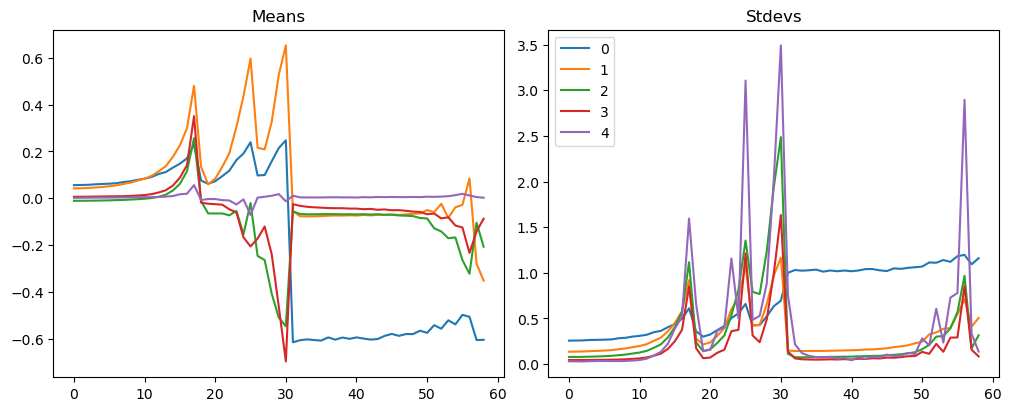

In [ ]:
astats.plot_stats()

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()